In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append(r'/mnt/s/_Data/160513 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# $N$ electrons, start by loading a realistic potential in 1D

In [25]:
# Load the data from the dsp file: 
reload(trap_analysis)
#path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/160524 - M016v5 resonator xz cut.dsp'
path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160524 - M016v5 resonator xz cut.dsp'
elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(path)

Could not import BEM module. Please do so manually.


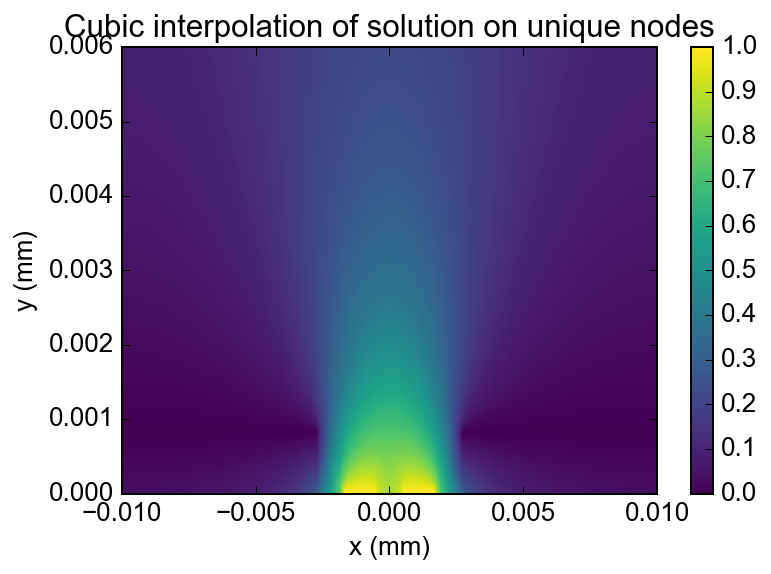

In [26]:
common.configure_axes(13)
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=np.linspace(0, 6E-3, 501), clim=(0.00, 1.00), 
                                                     plot_axes='xy', cmap=plt.cm.viridis)

Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ==============  =================
Parameter        Value              Std
===========  ==============  =================
a0           0.745357780096  0.000961054641372
a1           -37699.1848729    825.745762394
a2           -8353491043.12    126675606.125
===========  ==============  =================


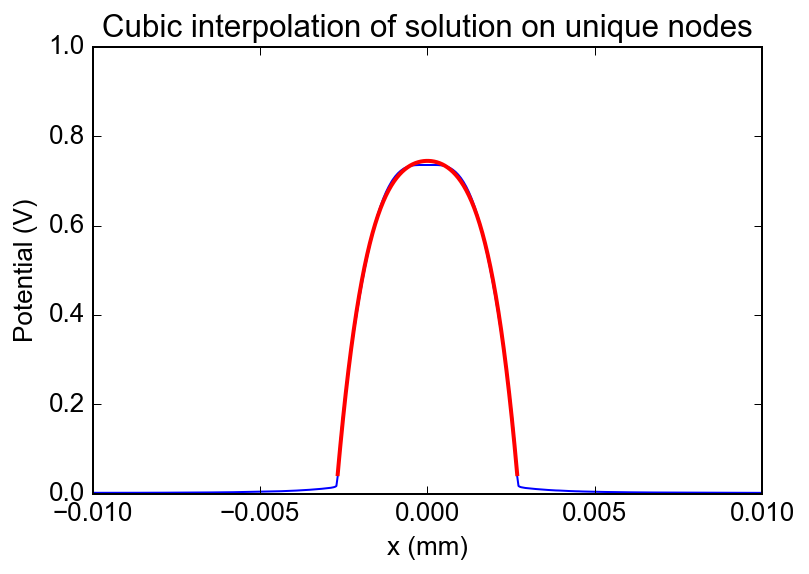

In [28]:
h = 0.76E-3
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=h, clim=(0.00, 1.00), plot_axes='xy',
                                                     cmap=plt.cm.viridis)

xplot = xinterp[0][np.logical_and(xinterp[0]>-2.7E-3, xinterp[0]<2.7E-3)]
fr, ferr = kfit.fit_poly(xinterp[0], Uinterp[0], mode='even', fitparams=[0, -1, -1], 
                         domain=(-2.7E-3, 2.7E-3))
plt.plot(xplot, kfit.polyfunc_even(xplot, *fr), '-r', lw=2.0)

In [57]:
c = trap_analysis.get_constants()
resV = 0.20
#ktrap = 2 * 0.0733 * 1E12 * c['e'] * resV

def Vext(xi):
    """
    Returns the overall potential that the electrons experience at position xi
    """
    V = - c['e'] * kfit.polyfunc_even(xi*1E3, *fr) * resV
    return V
    #return 0.5 * ktrap * xi**2

def Velectrons(xi, xj):
    """
    Returns the repulsion potential between two electrons separated by a distance |xi-xj|
    Note the factor 1/2. in front of the potential energy to avoid overcounting.
    """
    #print xi*1E6, xj*1E6
    return + 1/2. * c['e']**2/(4*np.pi*c['eps0']) * 1/np.abs(xi-xj)

def Vtotal(x):
    """
    Returns the total energy of N electrons
    """
    Vtot = np.sum(Vext(x))
    for n, xn in enumerate(x):
        Vtot += np.sum(Velectrons(np.delete(x.copy(),n), xn))
    return Vtot/c['e']

def plot_Vtotal(x, electron_positions):
    Vtot = len(electron_positions) * Vext(x)
    for n, xn in enumerate(electron_positions):
        Vtot += 2*Velectrons(x, xn)
    return Vtot/c['e']

In [68]:
from scipy.optimize import minimize
electron_initial_positions = np.linspace(-2E-6, 2E-6, 30)
res = minimize(Vtotal, electron_initial_positions, method='Nelder-Mead', 
               options={'disp': True, 'maxiter' : 1E6, 'maxfev' : 1E6}, tol=1E-12)
print res['x']

Optimization terminated successfully.
         Current function value: -3.059109
         Iterations: 50371
         Function evaluations: 59740
[ -1.90137895e-06  -1.71091364e-06  -1.55105850e-06  -1.40597214e-06
  -1.26968898e-06  -1.13919869e-06  -1.01271536e-06  -8.89093936e-07
  -7.67539594e-07  -6.47498966e-07  -5.28551400e-07  -4.10396539e-07
  -2.92788032e-07  -1.75538343e-07  -5.84923471e-08   5.84888247e-08
   1.75533371e-07   2.92782228e-07   4.10391515e-07   5.28545908e-07
   6.47491225e-07   7.67535308e-07   8.89086674e-07   1.01271370e-06
   1.13919525e-06   1.26968571e-06   1.40596561e-06   1.55104987e-06
   1.71090440e-06   1.90137077e-06]


-1.41303770667


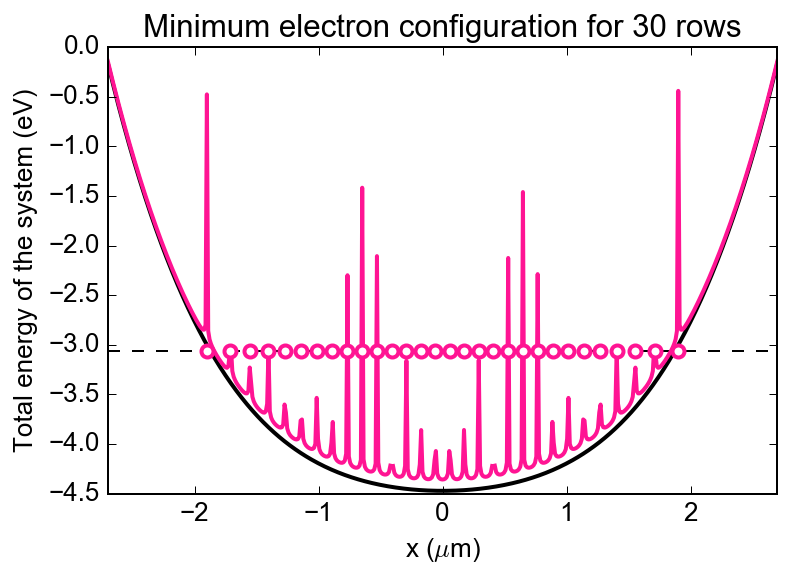

In [69]:
xs = np.linspace(-2.7E-6, 2.7E-6, 501)
electron_positions = res['x']
Vs = plot_Vtotal(xs, electron_positions)
Vs[np.where(Vs > 0.5)] = np.nan
V_at_minimum = res['fun']

plt.figure()
plt.plot(xs*1E6, len(electron_positions)*Vext(xs)/c['e'], '-k', lw=2.0)
plt.plot(xs*1E6, Vs, '-', lw=2.0, color='deeppink')
plt.hlines(V_at_minimum, np.min(xs)*1E6, np.max(xs)*1E6, linestyles='--')
plt.plot(electron_positions*1E6, V_at_minimum * np.ones(len(electron_positions)), 
         'o', **common.plot_opt('deeppink', msize=5, style='opaque'))
plt.xlabel("x ($\mu$m)")
plt.ylabel("Total energy of the system (eV)")
plt.xlim(np.min(xs)*1E6, np.max(xs)*1E6)
plt.title("Minimum electron configuration for %d rows"%(len(electron_positions)))

# This is the difference between the energy at the minized locations and the minimum of the potential landscape
print np.min(len(electron_positions)*Vext(xs)/c['e']) - V_at_minimum

#common.save_figure(plt.gcf(), save_path="S:\\Gerwin\\Electron on helium\\iPython notebooks\\Figures")

Can we compare the energy of the system at the minimum with the value we see a lot in the early papers? 
There the correction to the potential is given by $n_s e h/\varepsilon_{He}$, where $h$ is the channel depth, and $n_s$ is the local electron number density (number of electrons per unit area). 

In [70]:
# Estimate n_s: 
nl_estimate = 1/(np.mean(np.diff(np.sort(electron_positions))))
ns_estimate = nl_estimate ** 2
print ns_estimate

5.81568010579e+13


In [71]:
ns_estimate*c['e']*h*1E-3/(1.056*c['eps0'])

0.75765139128530368

It gives roughly the right number, but it depends a lot on how you define your estimate for $n_s$

(-2.7, 2.7)

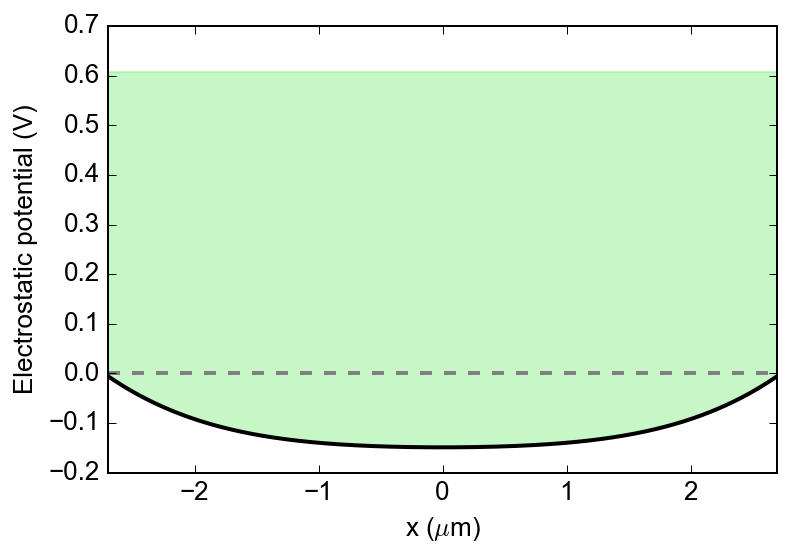

In [72]:
Ve=ns_estimate*c['e']*h*1E-3/(1.056*c['eps0'])

plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(xs*1E6, Vext(xs)/c['e'], color='k', lw=2.0)
plt.fill_between(xs*1E6, Vext(xs)/c['e'], y2=np.min(Vext(xs)/c['e'])+Ve, 
                 where=np.min(Vext(xs)/c['e'])+Ve > Vext(xs)/c['e'],
                 alpha=0.5, color='lightgreen')
plt.ylabel("Electrostatic potential (V)")
plt.xlabel("x ($\mu$m)")
plt.hlines(0, -2.7, 2.7, linestyles='--', color='gray', lw=2.0)
plt.xlim(-2.7, 2.7)
#plt.ylim(-resV, 0)

# Row number calculation following David Rees' recipe

We follow the recipe from David Rees, which is described over <a href=http://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.116.206801/PRLsupp.pdf>here</a>:
* Find the point where the electric field in the x-direction is 0. This defines the width of your charge sheet $w_e$
* Use the $E_z$ data just above and below the helium level to calculate the distribution within the sheet
* Integrate the profile obtained in previous step to get the number of rows

In [258]:
helium_level = 0.76E-3 # mm
Nxpoints = 2001

e = 1.602E-19 # C
eps0 = 8.85E-12 # F/m
epsHe = 1.056 # unitless

In [259]:
# Load the data from the dsp file: 
reload(trap_analysis)
path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160524 - M016v5 resonator xz cut.dsp'
elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(path)

Could not import BEM module. Please do so manually.


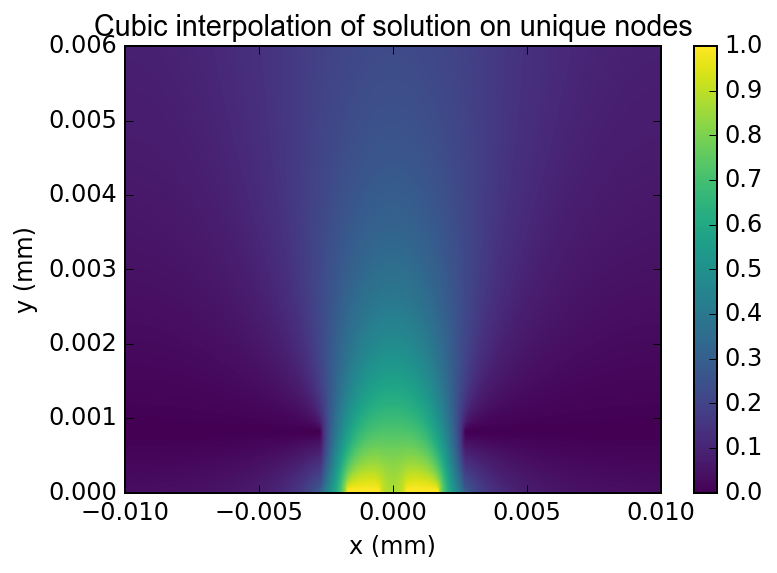

In [260]:
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, Nxpoints), 
                                                     yeval=np.linspace(0, 6E-3, 501), clim=(0.00, 1.00), 
                                                     plot_axes='xy', cmap=plt.cm.viridis)

## Calculating the smooth electron density across the channel $n_s$

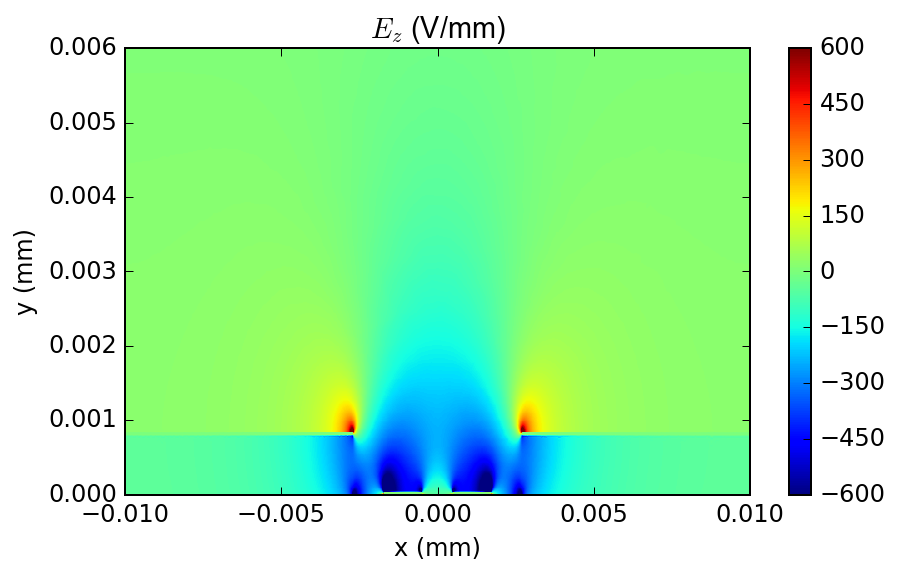

In [261]:
dz = yinterp[1,0]-yinterp[0,0]
Ez = (Uinterp[1:,:]-Uinterp[:-1,:])/dz
zplot = (yinterp[1:,:] + yinterp[:-1,:])/2

plt.figure(figsize=(7.,4.))
common.configure_axes(12)
plt.pcolormesh(xinterp[0,:], zplot[:,0], Ez)
#plt.plot((xinterp[0][1:]+xinterp[0][:-1])/2 , Ex)
plt.title("$E_z$ (V/mm)")
plt.ylabel("y (mm)")
plt.xlabel("x (mm)")
plt.xlim(np.min(xinterp[0,:]), np.max(xinterp[0,:]))
plt.clim(-600, 600)
plt.colorbar()

Taking the difference between Ez 12.00 nm above and 12.00 nm below the helium level (760.00 nm)


(-0.01, 0.01)

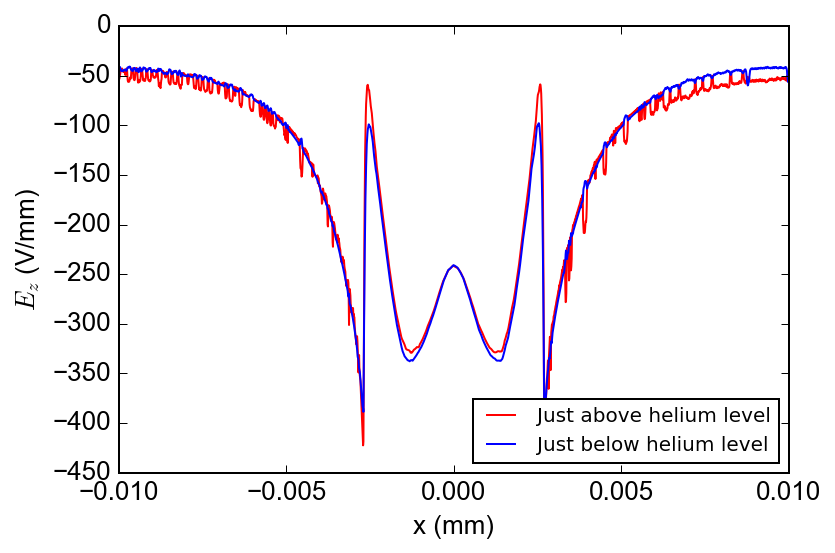

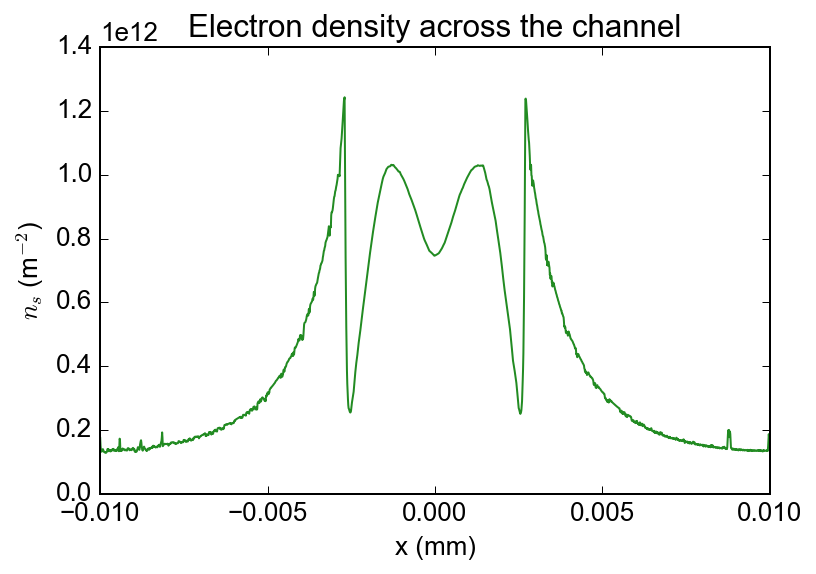

In [262]:
n = 1
print "Taking the difference between Ez %.2f nm above and %.2f nm below the helium level (%.2f nm)"\
%(n*dz*1E6, n*dz*1E6, helium_level*1E6)

idx = common.find_nearest(zplot[:,0], helium_level)

#ns = eps0/e * (epsHe*Ez[idx-n,:]-Ez[idx+n,:])*1E3 #Ez in V/mm, ns in m^-2
ns = eps0/e * Ez[idx,:]*(epsHe-1.0)*1E3 #Ez in V/mm, ns in m^-2

plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(xinterp[0,:], Ez[idx+n,:], 'r', label="Just above helium level")
plt.plot(xinterp[0,:], Ez[idx-n,:], 'b', label="Just below helium level")
plt.xlabel("x (mm)")
plt.ylabel("$E_z$ (V/mm)")
plt.legend(loc=0, prop={'size':10})
plt.xlim(np.min(xinterp[0,:]), np.max(xinterp[0,:]))

plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(xinterp[0,:], -ns, color='forestgreen')
plt.xlabel("x (mm)")
plt.ylabel("$n_s$ (m$^{-2}$)")
plt.title("Electron density across the channel")
plt.legend(loc=0)
plt.xlim(np.min(xinterp[0,:]), np.max(xinterp[0,:]))
#plt.xlim(-5E-3, 5E-3)

## Calculate the width of the electron ensemble $w_e$

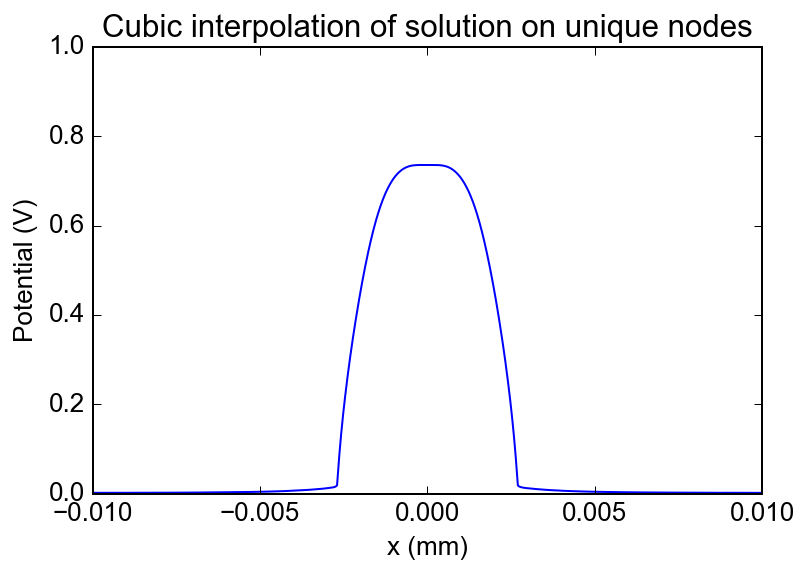

In [263]:
xinterp, yinterp, Vx = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, Nxpoints), 
                                                     yeval=helium_level, clim=(0.00, 1.00), plot_axes='xy',
                                                     cmap=plt.cm.viridis)

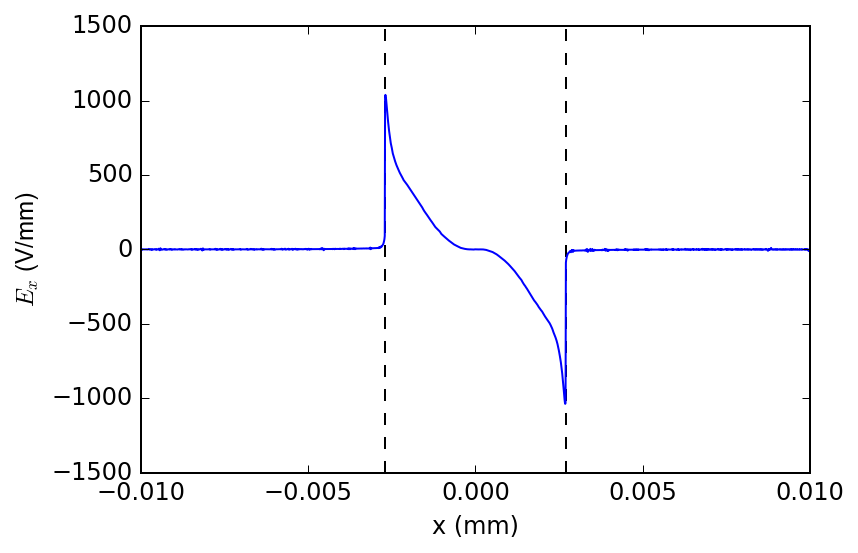

In [264]:
dx = xinterp[0][1]-xinterp[0][0]
Ex = (Vx[0][1:]-Vx[0][:-1])/dx
xplot = (xinterp[0][1:]+xinterp[0][:-1])/2

plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.plot(xplot, Ex)
plt.ylabel("$E_x$ (V/mm)")
plt.vlines([-2.7E-3, 2.7E-3], -1500, +1500, linestyles="--")
plt.xlabel("x (mm)")

## Calculate the number of rows

In [265]:
# Integrate to get the number of electron rows: 
we = 2*2.7E-3 # mm
min_idx = common.find_nearest(xplot, -we/2.)
max_idx = common.find_nearest(xplot, +we/2.)
nl = np.sum(ns[min_idx:max_idx+1] * dx * 1E-3) # ns in m^-2, dx in mm, nl in m^-1
Ny = sqrt(abs(we * 1E-3 * nl))

print Ny

4.81867761367


alternative method, as found in <a href="https://arxiv.org/abs/1607.05389">this</a> paper

In [249]:
Ny = we * 1E-3 * sqrt(np.mean(abs(ns[min_idx:max_idx+1])))

print Ny

4.81422206245
